<a href="https://colab.research.google.com/github/thxxx/datascience/blob/master/hospital3_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import 모음
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import graphviz

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/data/dacon/'
os.listdir(path) # path에 뭐가 들어있는지 보여준다.

['submission_sample.csv',
 'test.csv',
 'train.csv',
 'hospital.ipynb',
 'hospital2.ipynb',
 'Untitled',
 'hospital3.ipynb',
 'hospital3.ipynb의 사본']

In [4]:
# 파일 전부 읽는다.
tdf = pd.read_csv(os.path.join(path + 'train.csv'), encoding='utf-8')
test_df = pd.read_csv(os.path.join(path + 'test.csv'), encoding='utf-8')
sdf = pd.read_csv(os.path.join(path + 'submission_sample.csv'), encoding='utf-8')

In [5]:
tdf.head(10)

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,1.565244e+07,1.523624e+07,1.323624e+07,31641798.0,225169678.0,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,1.619468e+07,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,7.615600e+04,3.000000e+04,0.000000e+00,0.0,41864754.0,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,5.062231e+08,1.259568e+09,1.196881e+09,173769780.0,902830288.0,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,4.768078e+08,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,1.123523e+08,1.419089e+09,1.307249e+09,0.0,80749696.0,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,5.977481e+08,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same
5,11,open,gyeongnam,155,20020501,243.0,general_hospital,3.358054e+10,9.222997e+09,2.372791e+10,1.665533e+10,6.541432e+07,7.412694e+08,3.364622e+08,0.0,-46227375.0,5.635105e+09,5.481680e+09,6.634820e+08,1.534246e+08,1.864970e+10,1.849938e+10,1.364582e+08,0.0,0.000000e+00,1.849938e+10,1.718053e+10,0.000000e+00,0.000000e+00,0.000000e+00,3.664918e+09,3.433445e+10,9.839139e+09,2.409622e+10,1.638792e+10,1.256812e+08,4.500830e+08,4.155104e+08,0.0,7.468595e+07,4.869419e+09,4.725857e+09,1.976163e+08,1.435618e+08,

In [6]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [7]:
tdf['sido'].unique()

array(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], dtype=object)

##Train data의 전처리 작업

In [8]:
# revenue1이 NaN인건 다른 칼럼도 다 NaN인 row길래 드랍해버림
# 훨씬 코드를 잘짤 수 있다. 일단은 생각이 안나서 이따위로 함
# for i, x in enumerate(list(tdf['revenue1'].isna())):
#   if x == True:
#     print(tdf.drop(i, axis=0, inplace=True))
tdf.dropna(subset=['revenue1'], inplace=True)

# inst_id 는 아이디일 뿐인데 평가에 사용되는 듯해서 드랍해버렸다
tdf = tdf.drop(['inst_id'], axis=1)

In [9]:
sum(tdf['ownerChange']=='change')

42

In [10]:
# ownerChange의 Nan값들은 same으로 채운다. same이 241, change가 42개, NaN이 10개
tdf['ownerChange'] = tdf['ownerChange'].fillna('same')

In [11]:
# 오픈했는지 아닌지 OC open, close를 숫자 0,1로 바꿔준다.
tdf['OC'] = tdf['OC'].apply(lambda x: 0 if x=='open' else 1)

# String same, change를 0,1로 바꾼다.
tdf['ownerChange'] = tdf['ownerChange'].apply(lambda x: 0 if x=='same' else 1 )

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

items = ['gyeonggi', 'gyeongbuk', 'gyeongnam', 'busan', 'choongnam','jeonnam','seoul','jeonbuk','daegu','daejeon','choongbuk','gangwon',
         'incheon','ulsan','sejong', 'gwangju']

encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(items)

labels = labels.reshape(-1,1)

oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)
print('원핫 인코딩 데이터 \n', oh_labels.toarray())
# 근데 이거 어짜피 안쓴다. get_dummies()가 편하게 원핫인코딩 지원해서.

원핫 인코딩 데이터 
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
# 원핫 인코딩 아주 간단한 방법
tdf = pd.get_dummies(tdf, columns=['sido', 'instkind'])

In [14]:
#일단 instkind랑 sido는 여러 종류의 String이라서 드랍했다.
# tdf.drop(['instkind', 'sido'], axis=1, inplace=True)

print(tdf['bedCount'].max())

656.0


In [15]:
# bedCount, employee1,2 다 그냥 평균값으로 NaN 채움.
tdf['bedCount'] = tdf['bedCount'].fillna(tdf['bedCount'].mean()) # NaN인건 5개, 
tdf['employee1'] = tdf['employee1'].fillna(tdf['employee1'].mean())
tdf['employee2'] = tdf['employee2'].fillna(tdf['employee2'].mean())

In [16]:
# 값들의 정규화. MinMaxScaler는 데이터 값을 0과 1사이 값으로 변환
scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(tdf)
tdf[tdf.columns] = scaler.fit_transform(tdf[tdf.columns])
print("HI!")


HI!


In [17]:

tdf.head()

,OC,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,sido_busan,sido_choongbuk,sido_choongnam,sido_daegu,sido_daejeon,sido_gangwon,sido_gwangju,sido_gyeongbuk,sido_gyeonggi,sido_gyeongnam,sido_incheon,sido_jeonbuk,sido_jeonnam,sido_sejong,sido_seoul,sido_ulsan,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,0.0,0.406780,0.745497,0.266768,0.027931,0.000000,0.038458,0.031761,0.001712,0.001754,0.004658,0.011265,0.404356,0.023657,0.023873,0.033355,0.007268,0.016119,0.015133,0.014224,0.0,0.007876,0.005113,0.000000,0.008752,0.008535,0.144731,0.032220,0.031371,0.00000,0.041243,0.033678,0.004013,0.003397,0.006047,0.006739,0.298053,0.020338,0.020566,0.032045,0.007504,0.015537,0.014640,0.016640,0.0,0.008920,0.003255,0.000000,0.010409,0.011977,0.156855,0.056834,0.051667,0.053333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.497175,0.975981,0.713415,0.006652,0.005233,0.004342,0.004629,0.000008,0.000003,0.000000,0.000000,0.389296,0.006364,0.006070,0.000574,0.009073,0.000772,0.000772,0.000000,0.0,0.001066,0.002347,0.000000,0.000000,0.000000,0.128751,0.021290,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.138809,0.039006,0.195000,0.000833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.790960,0.565172,0.538110,0.480181,0.000000,0.686188,0.496381,0.055360,0.145005,0.421218,0.061864,0.460029,0.304649,0.276007,0.000000,0.728707,0.276791,0.245646,0.391189,0.0,0.488641,0.710925,1.000000,0.261225,0.176366,0.213908,0.084422,0.488017,0.00000,0.659944,0.484853,0.118142,0.153356,0.492573,0.078430,0.342040,0.272564,0.249098,0.000000,0.681584,0.241363,0.213839,0.446615,0.0,0.443714,0.248560,0.524017,0.402618,0.463738,0.228058,0.147560,0.552500,0.552500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.175141,0.693441,0.298780,0.324792,0.000000,0.462680,0.381987,0.012287,0.163369,0.460060,0.000000,0.392491,0.147567,0.140537,0.290885,0.214637,0.279919,0.277603,0.022046,0.0,0.575544,0.734222,0.901695,0.381496,0.328268,0.127406,0.087211,0.350969,0.00000,0.479026,0.382839,0.148108,0.172438,0.520502,0.000000,0.285833,0.120209,0.112429,0.205918,0.244318,0.283728,0.279935,0.090026,0.0,0.604459,0.439216,1.000000,0.414726,0.433274,0.138847,0.165576,0.171667,0.164167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.870056,0.615589,0.370427,0.222388,0.093631,0.230368,0.260095,0.007154,0.085337,0.118411,0.000000,0.382059,0.131636,0.131167,0.047080,0.074198,0.119549,0.118586,0.013531,0.0,0.000000,0.469839,0.863986,0.000000,0.000000,0.126864,0.048058,0.250616,0.11364,0.244934,0.267431,0.031141,0.050989,0.160221,0.000000,0.288766,0.119294,0.119023,0.012092,0.079219,0.134922,0.134117,0.021789,0.0,0.000000,0.319286,0.971205,0.000388,0.000000,0.138809,0.121451,0.330833,0.325000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
# OC는 정답이니까 따로 빼낸다!

skf = StratifiedKFold(n_splits=5)
n_iter = 0

train_label = tdf['OC']
tdf = tdf.drop(['OC'], axis=1)

[0.90816327 0.90816327 0.11340206]


NotFittedError: ignored

<Figure size 2592x720 with 0 Axes>

In [19]:
# 트레인 데이터 test, train으로 나눔
X_train, X_test, y_train, y_test = train_test_split(tdf.values, train_label, test_size=0.3, random_state=177)

In [20]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
# 예측
pred = rf_clf.predict(X_test)


In [20]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}
# 랜덤포레스트분류기 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼 파라미터 {grid_cv.best_params_}")
print(f"최고 예측 정확도 {grid_cv.best_score_}")

최적 하이퍼 파라미터 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 0.9463639824861984


In [22]:
# 위에서 얻은 최적 하이퍼 파라미터 대로 실행
rf_clf2 = RandomForestClassifier(random_state=0, max_depth = 6, min_samples_leaf = 8, min_samples_split = 8, n_estimators = 100)

rf_clf2.fit(X_train, y_train)
# 예측
pred2 = rf_clf2.predict(X_test)

In [24]:
# 정확도!
print("정확도 : ",accuracy_score(y_test, pred2))

정확도 :  0.9545454545454546


sgg   :  0.003909608531500173
openDate   :  0.10651347244171334
bedCount   :  0.013444407856213585
revenue1   :  0.031728208277923754
salescost1   :  0.013384821927471835
sga1   :  0.022220749882988212
salary1   :  0.013613780080878614
noi1   :  0.013167014775966388
noe1   :  0.0053821613919580145
interest1   :  0.03595840949687623
ctax1   :  0.00837205610800917
profit1   :  0.029818012149485373
liquidAsset1   :  0.02514080376046009
quickAsset1   :  0.05287858934324312
receivableS1   :  0.02569652644719217
inventoryAsset1   :  0.006672129197592891
nonCAsset1   :  0.0066988686037450385
tanAsset1   :  0.003793554590576965
OnonCAsset1   :  0.012599809213358253
debt1   :  0.017037397562239143
liquidLiabilities1   :  0.004686458713236342
shortLoan1   :  0.013118865481755572
NCLiabilities1   :  0.012913104214944935
longLoan1   :  0.01270908460591779
netAsset1   :  0.018150227944631035
revenue2   :  0.02500067460761954
salescost2   :  0.01249368420371967
sga2   :  0.02386601306268342
salary2 

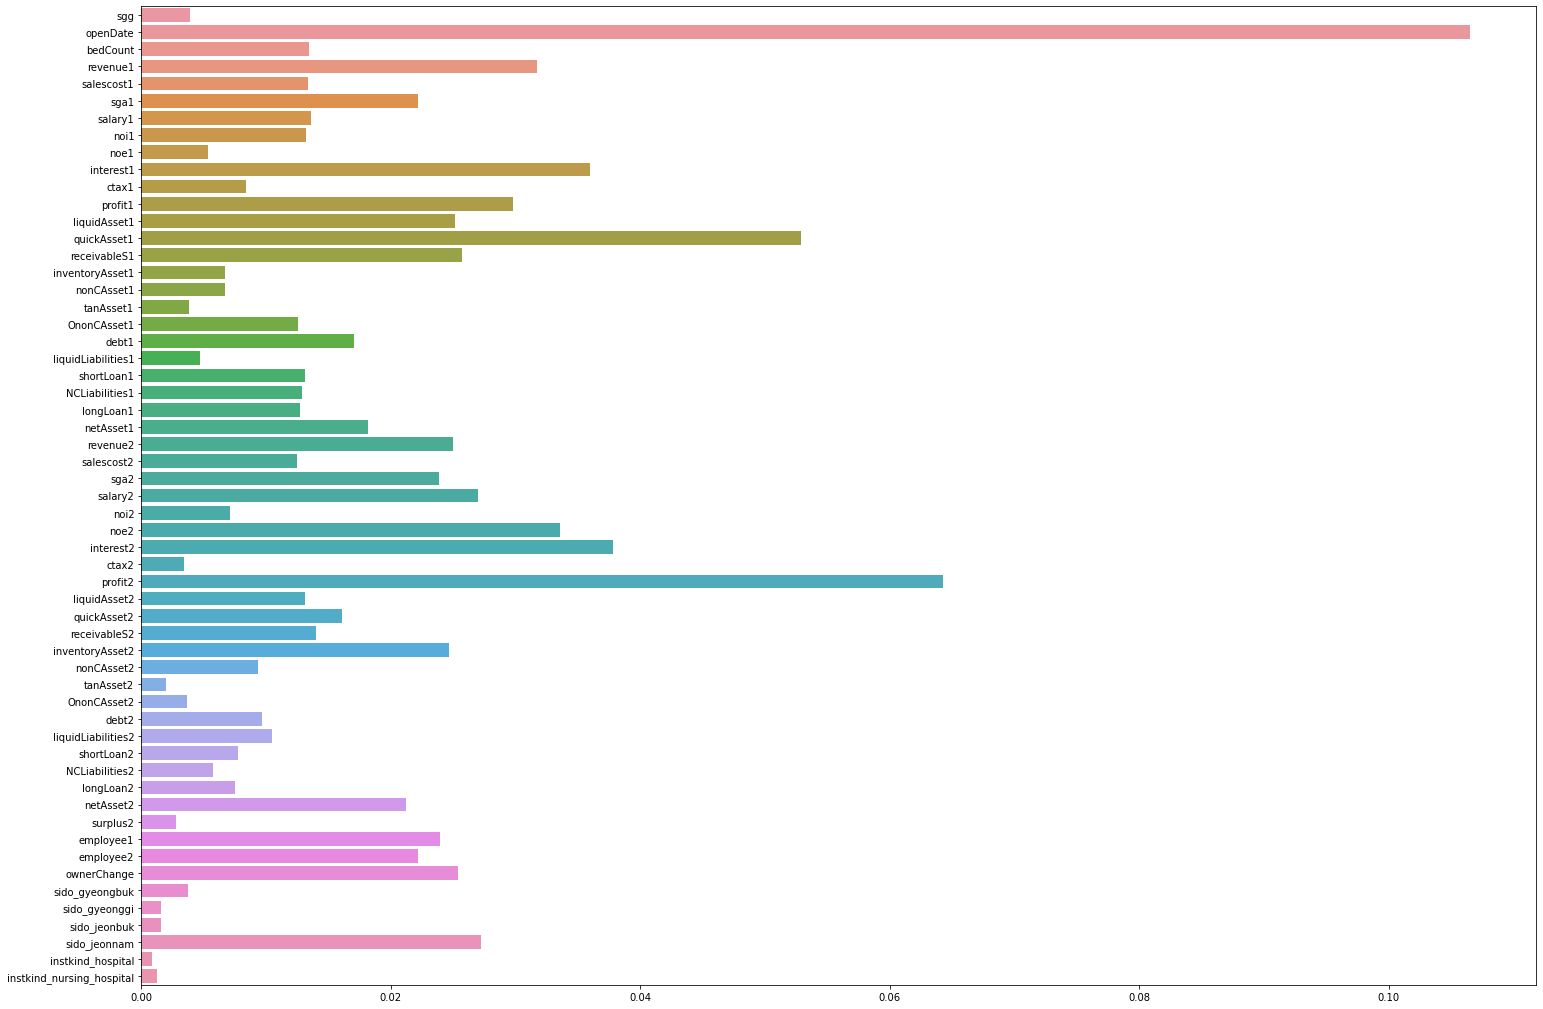

In [26]:
# 각 피처별 중요도를 그래프로 보여준다.
plt.figure(figsize=(25,18))

# sns.barplot(x=tdf.columns, y=dt_clf.feature_importances_)

feature = []
scoress = []


for index, score  in enumerate(rf_clf2.feature_importances_):
  if score > 0:
    print(tdf.columns[index], "  : ", score)
    feature.append(tdf.columns[index])
    scoress.append(score)

sns.barplot(x=scoress, y=feature)
